In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random

In [2]:
import keras
from keras.applications.resnet import ResNet50

In [3]:
!nvidia-smi

Tue Mar 11 20:50:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   42C    P8              5W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from keras.applications.resnet import preprocess_input, decode_predictions

modelresnet50 = ResNet50(weights='imagenet')
img_path = 'dataset/monkey_breed/train/n1/n1017.jpg'
img = keras.utils.load_img(img_path, target_size=(224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = modelresnet50.predict(x)
res = decode_predictions(preds, top=2)

print('Predicted:', decode_predictions(preds, top=2))

1/1 [==============================] - 60s 60s/step
Predicted: [[('n02486261', 'patas', 0.888169), ('n02484975', 'guenon', 0.075211726)]]


In [5]:
from keras.applications import MobileNet
true_model = MobileNet(include_top=False,
                       input_shape=(224,224,3),
                       weights='imagenet')

In [6]:
true_model = keras.applications.ResNet50(include_top=False,
                                         input_shape=(224,224,3),
                                         weights='imagenet')

In [7]:
pretrained_model = keras.applications.ResNet50(weights='imagenet')
                                             # include_top=False)

In [8]:
for layers in true_model.layers:
    layers.trainable = False

for i, layers in enumerate(true_model.layers):
    print(str(i)+" "+layers.__class__.__name__,layers.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

In [9]:
print(true_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
def addtopresnet50 (bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [11]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Input, Lambda
from keras.layers.normalization import batch_normalization

head = addtopresnet50(true_model,10)
model = Model(inputs=true_model.input, outputs=head)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_Aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               fill_mode='nearest',
                               horizontal_flip=True)
val_Aug = ImageDataGenerator(rescale=1./255)

train_generator = train_Aug.flow_from_directory("dataset/monkey_breed/train",
                                               target_size=(224,224),
                                               batch_size=16,
                                               class_mode="categorical")

val_generator = train_Aug.flow_from_directory("dataset/monkey_breed/validation",
                                               target_size=(224,224),
                                               batch_size=16,
                                               class_mode="categorical")

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop

early = EarlyStopping(monitor='val_loss',
                      patience=5,
                      verbose=2,
                      restore_best_weights=True)

checkpoint = ModelCheckpoint("models/model2_mobilenet_includetop.h5",
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor = 0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

model.compile(optimizer=RMSprop(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [10]:
history = model.fit_generator(train_generator,
                    validation_data=val_generator,
                    epochs=5,
                    verbose=1,
                    callbacks=[early, checkpoint])

C:\Users\user\AppData\Local\Temp\ipykernel_3572\4113053335.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/5
69/69 [==============================] - ETA: 0s - loss: 1.8417 - accuracy: 0.5237
Epoch 1: val_loss improved from inf to 0.75751, saving model to models\model2_mobilenet_includetop.h5
69/69 [==============================] - 138s 1s/step - loss: 1.8417 - accuracy: 0.5237 - val_loss: 0.7575 - val_accuracy: 0.7537
Epoch 2/5
69/69 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8479
Epoch 2: val_loss improved from 0.75751 to 0.26026, saving model to models\model2_mobilenet_includetop.h5
69/69 [==============================] - 59s 866ms/step - loss: 0.5175 - accuracy: 0.8479 - val_loss: 0.2603 - val_accuracy: 0.9007
Epoch 3/5
69/69 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.8989
Epoch 3: val_loss did not improve from 0.26026
69/69 [==============================] - 57s 827ms/step - loss: 0.3742 - accuracy: 0.8989 - val_loss: 0.3413 - val_accuracy: 0.8860
Epoch 4/5
69/69 [==============================] - ETA: 0s - loss: 0.367

In [15]:
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join("models", 'model1_mobilenet_0.92_0.19.h5'))

In [16]:
test_loss, test_accuracy = loaded_model.evaluate(val_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

17/17 [==============================] - 27s 1s/step - loss: 0.2570 - accuracy: 0.9118
Test Loss: 0.2569955289363861
Test Accuracy: 0.9117646813392639


In [17]:
predictions = loaded_model.predict(val_generator)
# print(f"Predictions: {predictions}")
predictions.shape

17/17 [==============================] - 14s 729ms/step


(272, 10)

1/1 [==============================] - 0s 28ms/step


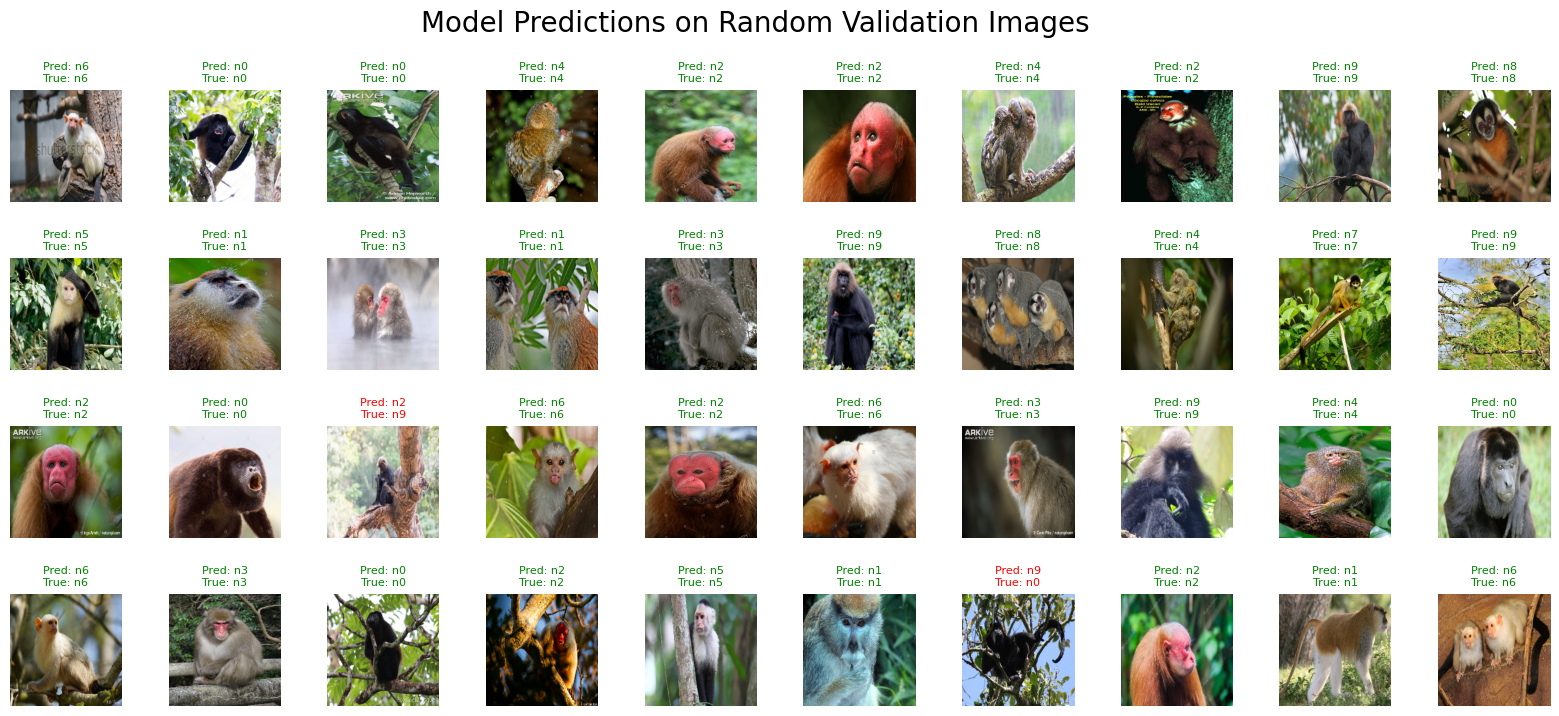

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from tensorflow.keras.models import load_model

model = load_model("models/model1_mobilenet_0.92_0.19.h5")
validation_dir = "dataset/monkey_breed/validation"

class_names = sorted(os.listdir(validation_dir))

image_files = []
image_labels = []
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(validation_dir, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            if img_file.endswith((".jpg", ".png")):
                image_files.append(os.path.join(class_folder, img_file))
                image_labels.append(class_name)

random_indices = random.sample(range(len(image_files)), 40)
random_images = [image_files[i] for i in random_indices]
true_labels = [image_labels[i] for i in random_indices]

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(20, 8))
fig.suptitle("Model Predictions on Random Validation Images", fontsize=20)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for idx, ax in enumerate(axes.flat):
    img_path = random_images[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]

    ax.imshow(img_resized)
    if predicted_class_name == true_labels[idx]:
        color = 'g'
    else:
        color = 'r'
    ax.set_title(f"Pred: {predicted_class_name}\nTrue: {true_labels[idx]}", fontsize=8, color=color)
    ax.axis("off")

plt.show()